## Install and import required libraries

In [1]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3
import os
os.environ["WANDB_DISABLED"] = "true"  # disable wandb logging


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
import numpy as np
import pandas as pd

from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    DataCollatorWithPadding,
    Trainer
)
from peft import LoraConfig, get_peft_model
from sklearn.metrics import accuracy_score
import torch.nn as nn


################################################################################
## 2. Load the AG News Dataset and Inspect Data
################################################################################

In [3]:
# Load the "train" split from AG News (over 120K articles)
dataset = load_dataset("ag_news", split="train")
print(f"Number of training examples: {len(dataset)}")
print("Sample training example:")
print(dataset[0])
# Expected columns: "text" and "label"


Number of training examples: 120000
Sample training example:
{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}


################################################################################
## 3. Compute Token‑Length Stats & Choose max_length
################################################################################

In [4]:
from transformers import AutoConfig, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
config = AutoConfig.from_pretrained("roberta-base", num_labels=4)
base_model = AutoModelForSequenceClassification.from_pretrained("roberta-base", config=config)

def length_fn(examples):
    return {"lengths": [len(tokenizer(x)["input_ids"]) for x in examples["text"]]}

sample = dataset.select(range(1000))
stats = sample.map(length_fn, batched=True)
lengths = stats["lengths"]
mean_len, std_len = np.mean(lengths), np.std(lengths)
max_length = int(mean_len + 2 * std_len)
print(f"Token lengths — mean: {mean_len:.1f}, std: {std_len:.1f}")
print(f"Setting max_length = {max_length}")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Token lengths — mean: 57.3, std: 27.3
Setting max_length = 111



################################################################################
## 4. Tokenization & Preprocessing for Training
################################################################################

In [5]:

def preprocess_function(examples):
    # Use the computed max_length for consistent truncation and padding
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=192, pad_to_max_length=True)

# Tokenize the entire dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=["text"])

tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

# Split into train and validation (e.g., 90% train, 10% validation)
split_data = tokenized_dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split_data["train"]
eval_dataset = split_data["test"]


################################################################################
## 5. Set Up the Model & Apply LoRA (PEFT)
################################################################################

In [6]:


# Use the already loaded model
model = base_model  # Already loaded with config

# Define label mappings
id2label = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
model.config.id2label = id2label
model.config.label2id = {v: k for k, v in id2label.items()}

# LoRA config
lora_config = LoraConfig(
    r=10,
    lora_alpha=28,
    lora_dropout=0.5,
    bias="none",
    target_modules=["query", "key"],
    task_type="SEQ_CLS"
)

# Wrap with LoRA
peft_model = get_peft_model(model, lora_config)
peft_model.config.id2label = id2label
peft_model.config.label2id = {v: k for k, v in id2label.items()}

# Add label_names if missing
if not hasattr(peft_model, "label_names"):
    peft_model.label_names = ["labels"]


# Add label smoothing loss
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(label_smoothing=0.15)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss


################################################################################
# 6. Define the Compute Metrics Function
################################################################################

In [7]:

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}



################################################################################
## 7. Data Collator and TrainingArguments Setup
################################################################################

In [8]:

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="results",
    logging_steps=50,
    save_strategy="no",
    eval_strategy="steps",           # ✅ try this instead of evaluation_strategy
    eval_steps=200,
    learning_rate=2e-5,
    lr_scheduler_type="cosine",
    warmup_ratio=0.15,
    weight_decay=0.05,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    seed=42,
    optim="adamw_torch",
    gradient_accumulation_steps=2,
    fp16=True,
    report_to=[]
)



# Count total vs. trainable parameters
total_params = sum(p.numel() for p in peft_model.parameters())
trainable_params = sum(p.numel() for p in peft_model.parameters() if p.requires_grad)
print(f"Total parameters:       {total_params:,}")
print(f"Trainable parameters:   {trainable_params:,}")
print(f"Trainable % of total:   {trainable_params/total_params*100:.2f}%")


Total parameters:       125,611,016
Trainable parameters:   962,308
Trainable % of total:   0.77%


################################################################################
## 8. Initialize Trainer and Begin Training
################################################################################

In [9]:
import warnings
warnings.filterwarnings("ignore")

trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)


print("Starting training...")
train_result = trainer.train()
print("Training completed.")


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Starting training...


Step,Training Loss,Validation Loss,Accuracy
200,1.386600,1.383629,0.252833
400,1.364800,1.362271,0.524167
600,1.258300,1.211203,0.874083
800,0.540900,0.419166,0.887500
1000,0.365600,0.317233,0.896750
1200,0.336500,0.301301,0.900083
1400,0.295900,0.292534,0.902500
1600,0.307800,0.286234,0.904250
1800,0.292500,0.280974,0.906083
2000,0.277900,0.277695,0.907500


Training completed.


################################################################################
## 9. Evaluate on the Validation Set
################################################################################

In [10]:

eval_result = trainer.evaluate()
print("Validation evaluation results:")
print(eval_result)


Validation evaluation results:
{'eval_loss': 0.2461387664079666, 'eval_accuracy': 0.91525, 'eval_runtime': 22.2561, 'eval_samples_per_second': 539.179, 'eval_steps_per_second': 8.447, 'epoch': 3.9979259259259257}


In [11]:
# Count total vs. trainable parameters
total_params = sum(p.numel() for p in peft_model.parameters())
trainable_params = sum(p.numel() for p in peft_model.parameters() if p.requires_grad)

print(f"Total parameters:       {total_params:,}")
print(f"Trainable parameters:   {trainable_params:,}")
print(f"Trainable % of total:   {trainable_params/total_params*100:.2f}%")


Total parameters:       125,611,016
Trainable parameters:   962,308
Trainable % of total:   0.77%


################################################################################
## 10. Final Corrected Inference Block (Safe Type Handling)
################################################################################

In [12]:

import traceback
from datasets import Dataset as HFDataset

try:
    obj = pd.read_pickle("test_unlabelled.pkl")
    test_df = obj.to_pandas() if isinstance(obj, HFDataset) else obj
    print("test_df loaded")

    if "text" not in test_df.columns:
        raise ValueError("'text' column missing from test_df")

    lens = test_df["text"].apply(lambda x: len(tokenizer(x)["input_ids"]))
    print(f"Token lengths — mean: {lens.mean():.1f}, std: {lens.std():.1f}")

    hf_test = HFDataset.from_pandas(test_df)
    hf_test = hf_test.map(lambda ex: tokenizer(ex["text"], padding="max_length", truncation=True, max_length=max_length), batched=True, remove_columns=["text"])
    preds = trainer.predict(hf_test).predictions.argmax(axis=-1)

    ids = test_df["ID"] if "ID" in test_df.columns else test_df["id"] if "id" in test_df.columns else list(range(len(preds)))
    submission = pd.DataFrame({"ID": ids, "Labels": preds})
    submission.to_csv("submission.csv", index=False)
    print("submission.csv saved!")

except FileNotFoundError:
    print("test_unlabelled.pkl not found.")
except Exception as e:
    print("Unexpected error during test processing or inference:")
    traceback.print_exc()


test_df loaded
Token lengths — mean: 64.4, std: 34.1


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

submission.csv saved!


################################################################################
## 11. Plots and Confusion Matrix
################################################################################

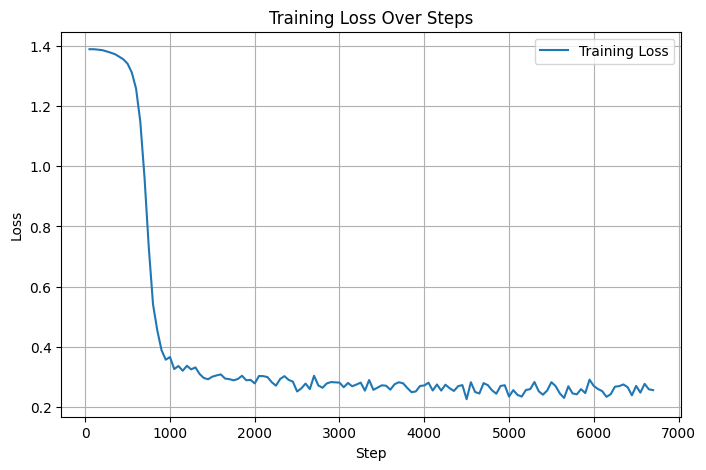

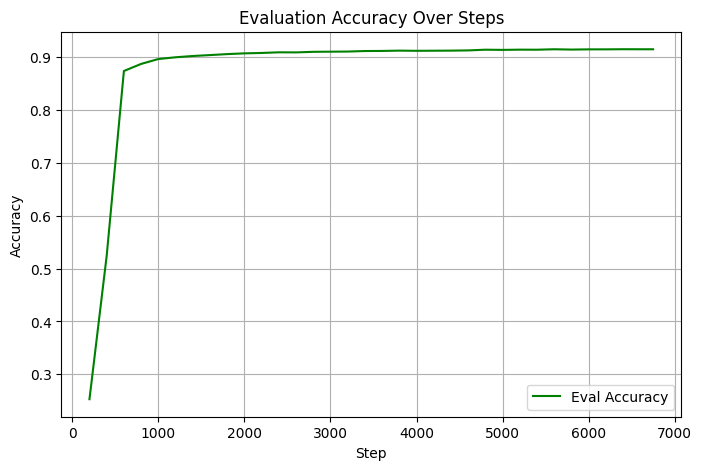

In [13]:
import matplotlib.pyplot as plt

# Extract logs
logs = trainer.state.log_history
steps = [log["step"] for log in logs if "loss" in log]
losses = [log["loss"] for log in logs if "loss" in log]
eval_steps = [log["step"] for log in logs if "eval_loss" in log]
eval_accuracies = [log["eval_accuracy"] for log in logs if "eval_accuracy" in log]

# Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(steps, losses, label='Training Loss')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Over Steps")
plt.grid()
plt.legend()
plt.show()

# Plot eval accuracy
plt.figure(figsize=(8, 5))
plt.plot(eval_steps, eval_accuracies, color='green', label='Eval Accuracy')
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy Over Steps")
plt.grid()
plt.legend()
plt.show()


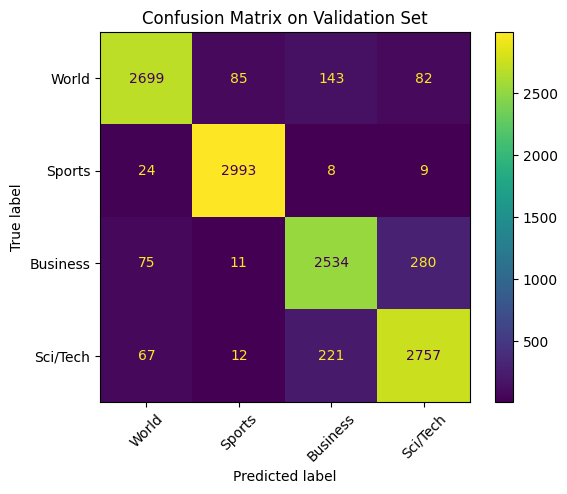

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds = trainer.predict(eval_dataset).predictions.argmax(-1)
labels = eval_dataset["labels"]
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=id2label.values())
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix on Validation Set")
plt.show()

